<a href="https://www.kaggle.com/code/shyamgupta196/few-shot-vs-transferl-wandb-pytorch-lightning?scriptVersionId=179080401" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Bone Fracture Classification 
<img src="https://t3.ftcdn.net/jpg/02/81/55/74/360_F_281557487_s15OrqyEEFjLXnq64qzfGTIt5YcJ9eJr.jpg" alt="Description of image">


In [1]:
import json
import os
import random
import urllib.request
from collections import defaultdict
from copy import deepcopy
from statistics import mean, stdev
from urllib.error import HTTPError

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from IPython.display import set_matplotlib_formats
from PIL import Image
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import CIFAR100, SVHN
from tqdm.auto import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import sys
import wandb
sys.path.append('/kaggle/usr/lib/wandblogin/')
from wandblogin import login
login()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
wandb.init('Transfer Learning vs Few shots Learning metric Comparisor')

wandb: Currently logged in as: shyamdgupta (shyam-d-gupta). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240522_074608-9845bdld
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run unique-planet-3
wandb: ⭐️ View project at https://wandb.ai/shyam-d-gupta/uncategorized
wandb: 🚀 View run at https://wandb.ai/shyam-d-gupta/uncategorized/runs/9845bdld


In [3]:
plt.set_cmap("cividis")
# %matplotlib inline
set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

# Import tensorboard
# %load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("/kaggle/input/bone-fracture-split-classification")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("/kaggle/working/", "saved_models/MetaLearning/")

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


/tmp/ipykernel_24/3623471220.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg", "pdf")  # For export


<Figure size 640x480 with 0 Axes>

In [4]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial16/"
# Files to download
pretrained_files = [
    "ProtoNet.ckpt",
    "ProtoMAML.ckpt",
    "tensorboards/ProtoNet/events.out.tfevents.ProtoNet",
    "tensorboards/ProtoMAML/events.out.tfevents.ProtoMAML",
    "protomaml_fewshot.json",
    "protomaml_svhn_fewshot.json",
]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print("Downloading %s..." % file_url)
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n",
                e,
            )

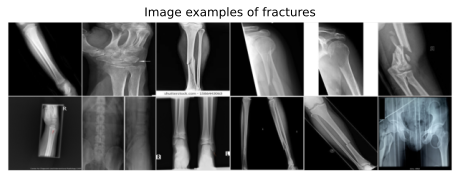

In [5]:
# Define transformations and dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),      # Resize images to 224x224
    transforms.ToTensor(),               # Convert images to PyTorch tensors
]) 

train_dataset = datasets.ImageFolder(root='/kaggle/input/bone-fracture-split-classification/train', transform=transform)

# Visualize some examples
NUM_IMAGES = 12
images = [train_dataset[np.random.randint(len(train_dataset))][0] for _ in range(NUM_IMAGES)]
images = torch.stack(images, dim=0)
img_grid = torchvision.utils.make_grid(images, nrow=6, normalize=False, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0).numpy()

# Scale image grid values to [0, 255] and convert to uint8
img_grid = (img_grid * 255).astype(np.uint8)

plt.figure(figsize=(8, 8))
plt.title("Image examples of fractures")
plt.imshow(img_grid)
plt.axis("off")

# Log to wandb
wandb.log({"samples": [wandb.Image(img_grid, caption="sample of images")]})

plt.show()
plt.close()


In [6]:
class ImageDataset(data.Dataset):
    def __init__(self, imgs, targets, img_transform=None):
        """
        Inputs:
            imgs - Numpy array of shape [N,32,32,3] containing all images.
            targets - PyTorch array of shape [N] containing all labels.
            img_transform - A torchvision transformation that should be applied
                            to the images before returning. If none, no transformation
                            is applied.
        """
        super().__init__()
        self.img_transform = img_transform
        self.imgs = imgs
        self.targets = targets

    def __getitem__(self, idx):
        img, target = self.imgs[idx], self.targets[idx]
        img = Image.fromarray(img)

        if self.img_transform is not None:
            img = self.img_transform(img)

        return img, target

    def __len__(self):
        return self.imgs.shape[0]

In [7]:
pl.seed_everything(0)  # Set seed for reproducibility
classes = torch.randperm(12)  # Returns random permutation of numbers 0 to 99
train_classes, val_classes, test_classes = classes[:8], classes[8:10], classes[10:]

In [8]:
# Printing validation and test classes
idx_to_class = {val: key for key, val in train_dataset.class_to_idx.items()}
print("Validation classes:", [idx_to_class[c.item()] for c in val_classes])
print("Test classes:", [idx_to_class[c.item()] for c in test_classes])

Validation classes: ['Fracture Dislocation', 'Comminuted fracture']
Test classes: ['Spiral Fracture', 'Impacted fracture']


In [9]:
def dataset_from_labels(imgs, targets, class_set, **kwargs):
    class_mask = (targets[:, None] == class_set[None, :]).any(dim=-1)
    return ImageDataset(imgs=imgs[class_mask], targets=targets[class_mask], **kwargs)

In [10]:
class FewShotBatchSampler:
    def __init__(self, dataset_targets, N_way, K_shot, include_query=False, shuffle=True, shuffle_once=False):
        """
        Inputs:
            dataset_targets - PyTorch tensor of the labels of the data elements.
            N_way - Number of classes to sample per batch.
            K_shot - Number of examples to sample per class in the batch.
            include_query - If True, returns batch of size N_way*K_shot*2, which
                            can be split into support and query set. Simplifies
                            the implementation of sampling the same classes but
                            distinct examples for support and query set.
            shuffle - If True, examples and classes are newly shuffled in each
                      iteration (for training)
            shuffle_once - If True, examples and classes are shuffled once in
                           the beginning, but kept constant across iterations
                           (for validation)
        """
        super().__init__()
        self.dataset_targets = dataset_targets
        self.N_way = N_way
        self.K_shot = K_shot
        self.shuffle = shuffle
        self.include_query = include_query
        if self.include_query:
            self.K_shot *= 2
        self.batch_size = self.N_way * self.K_shot  # Number of overall images per batch

        # Organize examples by class
        self.classes = torch.unique(torch.tensor(self.dataset_targets)).tolist()
        self.num_classes = len(self.classes)
        self.indices_per_class = {}
        self.batches_per_class = {}  # Number of K-shot batches that each class can provide
        for c in self.classes:
            self.indices_per_class[c] = torch.where(torch.tensor(self.dataset_targets) == c)[0]
            self.batches_per_class[c] = self.indices_per_class[c].shape[0] // self.K_shot

        # Create a list of classes from which we select the N classes per batch
        self.iterations = sum(self.batches_per_class.values()) // self.N_way
        self.class_list = [c for c in self.classes for _ in range(self.batches_per_class[c])]
        if shuffle_once or self.shuffle:
            self.shuffle_data()
        else:
            # For testing, we iterate over classes instead of shuffling them
            sort_idxs = [
                i + p * self.num_classes for i, c in enumerate(self.classes) for p in range(self.batches_per_class[c])
            ]
            self.class_list = np.array(self.class_list)[np.argsort(sort_idxs)].tolist()

    def shuffle_data(self):
        # Shuffle the examples per class
        for c in self.classes:
            perm = torch.randperm(self.indices_per_class[c].shape[0])
            self.indices_per_class[c] = self.indices_per_class[c][perm]
        # Shuffle the class list from which we sample. Note that this way of shuffling
        # does not prevent to choose the same class twice in a batch. However, for
        # training and validation, this is not a problem.
        random.shuffle(self.class_list)

    def __iter__(self):
        # Shuffle data
        if self.shuffle:
            self.shuffle_data()

        # Sample few-shot batches
        start_index = defaultdict(int)
        for it in range(self.iterations):
            class_batch = self.class_list[it * self.N_way : (it + 1) * self.N_way]  # Select N classes for the batch
            index_batch = []
            for c in class_batch:  # For each class, select the next K examples and add them to the batch
                index_batch.extend(self.indices_per_class[c][start_index[c] : start_index[c] + self.K_shot])
                start_index[c] += self.K_shot
            if self.include_query:  # If we return support+query set, sort them so that they are easy to split
                index_batch = index_batch[::2] + index_batch[1::2]
            yield index_batch

    def __len__(self):
        return self.iterations

In [11]:
N_WAY = 7
K_SHOT = 20
train_data_loader = data.DataLoader(
    train_dataset,
    batch_sampler=FewShotBatchSampler(torch.tensor(train_dataset.targets), include_query=True, N_way=N_WAY, K_shot=K_SHOT, shuffle=True),
    num_workers=4,
)

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Define your test dataset
test_dataset = datasets.ImageFolder(root='/kaggle/input/bone-fracture-split-classification/test', transform=test_transform)

val_data_loader = data.DataLoader(
    test_dataset,
    batch_sampler=FewShotBatchSampler(
        torch.tensor(test_dataset.targets), include_query=True, N_way=N_WAY, K_shot=K_SHOT, shuffle=False, shuffle_once=True
    ),
    num_workers=4,
)

/tmp/ipykernel_24/3344204757.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.classes = torch.unique(torch.tensor(self.dataset_targets)).tolist()
/tmp/ipykernel_24/3344204757.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.indices_per_class[c] = torch.where(torch.tensor(self.dataset_targets) == c)[0]


In [12]:
def split_batch(imgs, targets):
    support_imgs, query_imgs = imgs.chunk(2, dim=0)
    support_targets, query_targets = targets.chunk(2, dim=0)
    return support_imgs, query_imgs, support_targets, query_targets

In [13]:
imgs, targets = next(iter(val_data_loader))  # Use the validation set since it does not apply augmentations
support_imgs, query_imgs, _, _ = split_batch(imgs, targets)
support_grid = torchvision.utils.make_grid(support_imgs, nrow=K_SHOT, normalize=True, pad_value=0.9)
support_grid = support_grid.permute(1, 2, 0).numpy()
query_grid = torchvision.utils.make_grid(query_imgs, nrow=K_SHOT, normalize=True, pad_value=0.9)
query_grid = query_grid.permute(1, 2, 0).numpy()


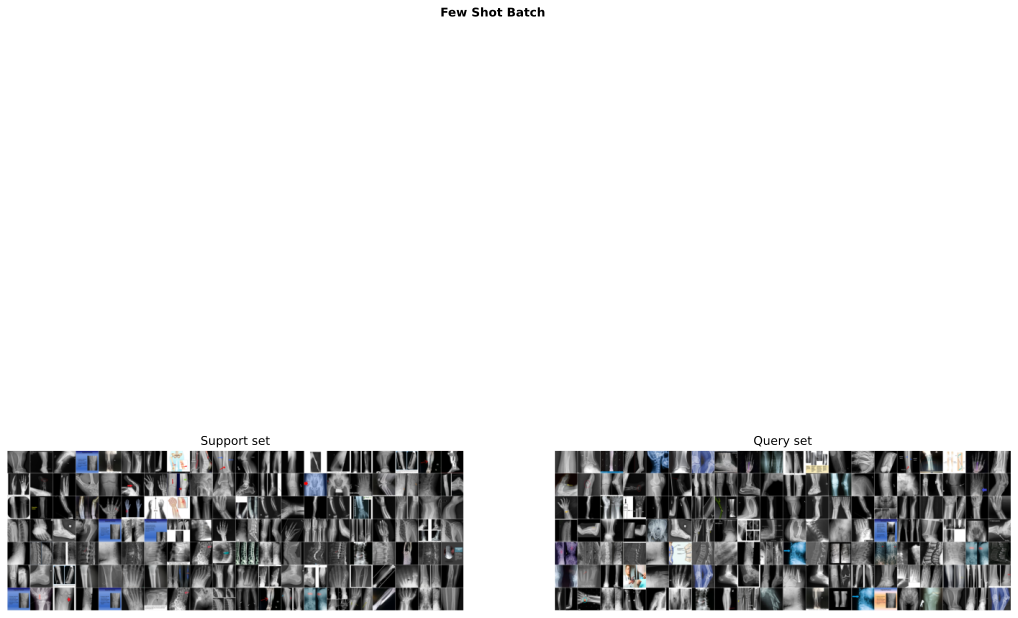

In [14]:

fig, ax = plt.subplots(1, 2, figsize=(18, 15))
ax[0].imshow(support_grid)
ax[0].set_title("Support set")
ax[0].axis("off")
ax[1].imshow(query_grid)
ax[1].set_title("Query set")
ax[1].axis("off")
fig.suptitle("Few Shot Batch", weight="bold")
fig.show()
# plt.close(fig)

In [15]:

# Log the support and query grids to wandb
wandb.log({
    "support_set": wandb.Image(support_grid, caption="Support set"),
    "query_set": wandb.Image(query_grid, caption="Query set")
})


In [16]:
def get_convnet(output_size):
    convnet = torchvision.models.DenseNet(
        growth_rate=32,
        block_config=(6, 6, 6, 6),
        bn_size=2,
        num_init_features=64,
        num_classes=output_size,  # Output dimensionality
    )
    return convnet

In [17]:
class ProtoNet(pl.LightningModule):
    def __init__(self, proto_dim, lr):
        """Inputs.

        proto_dim - Dimensionality of prototype feature space
        lr - Learning rate of Adam optimizer
        """
        super().__init__()
        self.save_hyperparameters()
        self.model = get_convnet(output_size=self.hparams.proto_dim)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[140, 180], gamma=0.1)
        return [optimizer], [scheduler]

    @staticmethod
    def calculate_prototypes(features, targets):
        # Given a stack of features vectors and labels, return class prototypes
        # features - shape [N, proto_dim], targets - shape [N]
        classes, _ = torch.unique(targets).sort()  # Determine which classes we have
        prototypes = []
        for c in classes:
            p = features[torch.where(targets == c)[0]].mean(dim=0)  # Average class feature vectors
            prototypes.append(p)
        prototypes = torch.stack(prototypes, dim=0)
        # Return the 'classes' tensor to know which prototype belongs to which class
        return prototypes, classes

    def classify_feats(self, prototypes, classes, feats, targets):
        # Classify new examples with prototypes and return classification error
        dist = torch.pow(prototypes[None, :] - feats[:, None], 2).sum(dim=2)  # Squared euclidean distance
        preds = F.log_softmax(-dist, dim=1)
        labels = (classes[None, :] == targets[:, None]).long().argmax(dim=-1)
        acc = (preds.argmax(dim=1) == labels).float().mean()
        return preds, labels, acc

    def calculate_loss(self, batch, mode):
        # Determine training loss for a given support and query set
        imgs, targets = batch
        features = self.model(imgs)  # Encode all images of support and query set
        support_feats, query_feats, support_targets, query_targets = split_batch(features, targets)
        prototypes, classes = ProtoNet.calculate_prototypes(support_feats, support_targets)
        preds, labels, acc = self.classify_feats(prototypes, classes, query_feats, query_targets)
        loss = F.cross_entropy(preds, labels)

        self.log("%s_loss" % mode, loss)
        self.log("%s_acc" % mode, acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self.calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self.calculate_loss(batch, mode="val")

In [18]:
def train_model(model_class, train_loader, val_loader, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, model_class.__name__),accelerator='cuda' if str(device) == "cuda:0" else 'cpu',
        max_epochs=200,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],enable_progress_bar=0
    )
    trainer.logger._default_hp_metric = None

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, model_class.__name__ + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        # Automatically loads the model with the saved hyperparameters
        model = model_class.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = model_class(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = model_class.load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path
        )  # Load best checkpoint after training

    return model

In [19]:
protonet_model = train_model(
    ProtoNet, proto_dim=64, lr=2e-4, train_loader=train_data_loader, val_loader=val_data_loader
)

Found pretrained model at saved_models/MetaLearning/ProtoNet.ckpt, loading...


In [20]:

@torch.no_grad()
def test_proto_net(model, dataset, data_feats=None, k_shot=4):
    model = model.to(device)
    model.eval()
    num_classes = len(set(dataset.targets))
    
    # Calculate examples per class, assuming uniform distribution
    class_counts = torch.bincount(torch.tensor(dataset.targets))
    exmps_per_class = class_counts.min().item()
    
    if data_feats is None:
        dataloader = data.DataLoader(dataset, batch_size=128, num_workers=4, shuffle=False, drop_last=False)

        img_features = []
        img_targets = []
        for imgs, targets in tqdm(dataloader, "Extracting image features", leave=False):
            imgs = imgs.to(device)
            feats = model.model(imgs)
            img_features.append(feats.detach().cpu())
            img_targets.append(targets)
        img_features = torch.cat(img_features, dim=0)
        img_targets = torch.cat(img_targets, dim=0)
        
        # Sort by classes
        img_targets, sort_idx = img_targets.sort()
        img_features = img_features[sort_idx]
        
        # Group by class
        class_indices = [torch.where(img_targets == i)[0] for i in range(num_classes)]
        img_features = [img_features[idx] for idx in class_indices]
        img_targets = [img_targets[idx] for idx in class_indices]
        
        # Ensure that all classes have the same number of examples
        min_exmps_per_class = min(len(f) for f in img_features)
        img_features = [f[:min_exmps_per_class] for f in img_features]
        img_targets = [t[:min_exmps_per_class] for t in img_targets]

        # Stack features and targets
        img_features = torch.stack(img_features).transpose(0, 1)
        img_targets = torch.stack(img_targets).transpose(0, 1)
    else:
        img_features, img_targets = data_feats

    accuracies = []
    for k_idx in tqdm(range(0, img_features.shape[0], k_shot), "Evaluating prototype classification", leave=False):
        if k_idx + k_shot > img_features.shape[0]:
            continue
        
        k_img_feats = img_features[k_idx : k_idx + k_shot].flatten(0, 1)
        k_targets = img_targets[k_idx : k_idx + k_shot].flatten(0, 1)
        prototypes, proto_classes = model.calculate_prototypes(k_img_feats, k_targets)
        
        batch_acc = 0
        num_evaluations = 0
        for e_idx in range(0, img_features.shape[0], k_shot):
            if k_idx == e_idx:
                continue
            if e_idx + k_shot > img_features.shape[0]:
                continue
            e_img_feats = img_features[e_idx : e_idx + k_shot].flatten(0, 1)
            e_targets = img_targets[e_idx : e_idx + k_shot].flatten(0, 1)
            _, _, acc = model.classify_feats(prototypes, proto_classes, e_img_feats, e_targets)
            batch_acc += acc.item()
            num_evaluations += 1
        if num_evaluations > 0:
            batch_acc /= num_evaluations
            accuracies.append(batch_acc)

    if len(accuracies) > 1:
        acc_mean = mean(accuracies)
        acc_stdev = stdev(accuracies)
    elif len(accuracies) == 1:
        acc_mean = accuracies[0]
        acc_stdev = 0.0
    else:
        acc_mean = 0.0
        acc_stdev = 0.0

    return (acc_mean, acc_stdev), (img_features, img_targets)

# Example of using the function
protonet_accuracies = dict()
data_feats = None
for k in [2, 4, 8, 16, 32]:
    protonet_accuracies[k], data_feats = test_proto_net(protonet_model, test_dataset, data_feats=data_feats, k_shot=k)
    print("Accuracy for k=%i: %4.2f%% (+-%4.2f%%)" % (k, 100.0 * protonet_accuracies[k][0], 100 * protonet_accuracies[k][1]))
    
    # Log the metrics to wandb
    wandb.log({
        f"accuracy_k_{k}": protonet_accuracies[k][0],
        f"stdev_k_{k}": protonet_accuracies[k][1]
    })


Extracting image features:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating prototype classification:   0%|          | 0/16 [00:00<?, ?it/s]

Accuracy for k=2: 10.50% (+-1.80%)


Evaluating prototype classification:   0%|          | 0/8 [00:00<?, ?it/s]

Accuracy for k=4: 11.31% (+-2.09%)


Evaluating prototype classification:   0%|          | 0/4 [00:00<?, ?it/s]

Accuracy for k=8: 12.76% (+-2.88%)


Evaluating prototype classification:   0%|          | 0/2 [00:00<?, ?it/s]

Accuracy for k=16: 12.24% (+-1.10%)


Evaluating prototype classification:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy for k=32: 0.00% (+-0.00%)


In [21]:
def plot_few_shot(acc_dict, name, color=None, ax=None):
    sns.set()
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    ks = sorted(list(acc_dict.keys()))
    mean_accs = [acc_dict[k][0] for k in ks]
    std_accs = [acc_dict[k][1] for k in ks]
    ax.plot(ks, mean_accs, marker="o", markeredgecolor="k", markersize=6, label=name, color=color)
    ax.fill_between(
        ks,
        [m - s for m, s in zip(mean_accs, std_accs)],
        [m + s for m, s in zip(mean_accs, std_accs)],
        alpha=0.2,
        color=color,
    )
    ax.set_xticks(ks)
    ax.set_xlim([ks[0] - 1, ks[-1] + 1])
    ax.set_xlabel("Number of shots per class", weight="bold")
    ax.set_ylabel("Accuracy", weight="bold")
    if len(ax.get_title()) == 0:
        ax.set_title("Few-Shot Performance " + name, weight="bold")
    else:
        ax.set_title(ax.get_title() + " and " + name, weight="bold")
    ax.legend()
    return ax

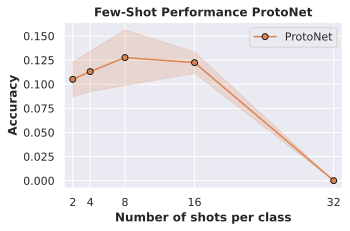

In [22]:
ax = plot_few_shot(protonet_accuracies, name="ProtoNet", color="C1")
wandb.log({"accuracy plots": [wandb.Image(ax)]})
plt.show()
plt.close()

In [23]:
class ProtoMAML(pl.LightningModule):
    def __init__(self, proto_dim, lr, lr_inner, lr_output, num_inner_steps):
        """Inputs.

        proto_dim - Dimensionality of prototype feature space
        lr - Learning rate of the outer loop Adam optimizer
        lr_inner - Learning rate of the inner loop SGD optimizer
        lr_output - Learning rate for the output layer in the inner loop
        num_inner_steps - Number of inner loop updates to perform
        """
        super().__init__()
        self.save_hyperparameters()
        self.model = get_convnet(output_size=self.hparams.proto_dim)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[140, 180], gamma=0.1)
        return [optimizer], [scheduler]

    def run_model(self, local_model, output_weight, output_bias, imgs, labels):
        # Execute a model with given output layer weights and inputs
        feats = local_model(imgs)
        preds = F.linear(feats, output_weight, output_bias)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=1) == labels).float()
        return loss, preds, acc

    def adapt_few_shot(self, support_imgs, support_targets):
        # Determine prototype initialization
        support_feats = self.model(support_imgs)
        prototypes, classes = ProtoNet.calculate_prototypes(support_feats, support_targets)
        support_labels = (classes[None, :] == support_targets[:, None]).long().argmax(dim=-1)
        # Create inner-loop model and optimizer
        local_model = deepcopy(self.model)
        local_model.train()
        local_optim = optim.SGD(local_model.parameters(), lr=self.hparams.lr_inner)
        local_optim.zero_grad()
        # Create output layer weights with prototype-based initialization
        init_weight = 2 * prototypes
        init_bias = -torch.norm(prototypes, dim=1) ** 2
        output_weight = init_weight.detach().requires_grad_()
        output_bias = init_bias.detach().requires_grad_()

        # Optimize inner loop model on support set
        for _ in range(self.hparams.num_inner_steps):
            # Determine loss on the support set
            loss, _, _ = self.run_model(local_model, output_weight, output_bias, support_imgs, support_labels)
            # Calculate gradients and perform inner loop update
            loss.backward()
            local_optim.step()
            # Update output layer via SGD
            output_weight.data -= self.hparams.lr_output * output_weight.grad
            output_bias.data -= self.hparams.lr_output * output_bias.grad
            # Reset gradients
            local_optim.zero_grad()
            output_weight.grad.fill_(0)
            output_bias.grad.fill_(0)

        # Re-attach computation graph of prototypes
        output_weight = (output_weight - init_weight).detach() + init_weight
        output_bias = (output_bias - init_bias).detach() + init_bias

        return local_model, output_weight, output_bias, classes

    def outer_loop(self, batch, mode="train"):
        accuracies = []
        losses = []
        self.model.zero_grad()

        # Determine gradients for batch of tasks
        for task_batch in batch:
            imgs, targets = task_batch
            support_imgs, query_imgs, support_targets, query_targets = split_batch(imgs, targets)
            # Perform inner loop adaptation
            local_model, output_weight, output_bias, classes = self.adapt_few_shot(support_imgs, support_targets)
            # Determine loss of query set
            query_labels = (classes[None, :] == query_targets[:, None]).long().argmax(dim=-1)
            loss, preds, acc = self.run_model(local_model, output_weight, output_bias, query_imgs, query_labels)
            # Calculate gradients for query set loss
            if mode == "train":
                loss.backward()

                for p_global, p_local in zip(self.model.parameters(), local_model.parameters()):
                    p_global.grad += p_local.grad  # First-order approx. -> add gradients of finetuned and base model

            accuracies.append(acc.mean().detach())
            losses.append(loss.detach())

        # Perform update of base model
        if mode == "train":
            opt = self.optimizers()
            opt.step()
            opt.zero_grad()

        avg_loss = sum(losses) / len(losses)
        avg_acc = sum(accuracies) / len(accuracies)

        self.log(f"{mode}_loss", avg_loss)
        self.log(f"{mode}_acc", avg_acc)

        # Log to wandb
        wandb.log({
            f"{mode}_loss": avg_loss.item(),
            f"{mode}_acc": avg_acc.item()
        })

    def training_step(self, batch, batch_idx):
        self.outer_loop(batch, mode="train")
        return None  # Returning None means we skip the default training optimizer steps by PyTorch Lightning

    def validation_step(self, batch, batch_idx):
        # Validation requires to finetune a model, hence we need to enable gradients
        torch.set_grad_enabled(True)
        self.outer_loop(batch, mode="val")
        torch.set_grad_enabled(False)

In [24]:
class TaskBatchSampler:
    def __init__(self, dataset_targets, batch_size, N_way, K_shot, include_query=False, shuffle=True):
        """
        Inputs:
            dataset_targets - PyTorch tensor of the labels of the data elements.
            batch_size - Number of tasks to aggregate in a batch
            N_way - Number of classes to sample per batch.
            K_shot - Number of examples to sample per class in the batch.
            include_query - If True, returns batch of size N_way*K_shot*2, which
                            can be split into support and query set. Simplifies
                            the implementation of sampling the same classes but
                            distinct examples for support and query set.
            shuffle - If True, examples and classes are newly shuffled in each
                      iteration (for training)
        """
        super().__init__()
        self.batch_sampler = FewShotBatchSampler(dataset_targets, N_way, K_shot, include_query, shuffle)
        self.task_batch_size = batch_size
        self.local_batch_size = self.batch_sampler.batch_size

    def __iter__(self):
        # Aggregate multiple batches before returning the indices
        batch_list = []
        for batch_idx, batch in enumerate(self.batch_sampler):
            batch_list.extend(batch)
            if (batch_idx + 1) % self.task_batch_size == 0:
                yield batch_list
                batch_list = []

    def __len__(self):
        return len(self.batch_sampler) // self.task_batch_size

    def get_collate_fn(self):
        # Returns a collate function that converts one big tensor into a list of task-specific tensors
        def collate_fn(item_list):
            imgs = torch.stack([img for img, target in item_list], dim=0)
            targets = torch.stack([target for img, target in item_list], dim=0)
            imgs = imgs.chunk(self.task_batch_size, dim=0)
            targets = targets.chunk(self.task_batch_size, dim=0)
            return list(zip(imgs, targets))

        return collate_fn

In [25]:
# Training constant (same as for ProtoNet)
N_WAY = 7
K_SHOT = 20

# Training set
train_protomaml_sampler = TaskBatchSampler(
    train_dataset.targets, include_query=True, N_way=N_WAY, K_shot=K_SHOT, batch_size=16
)
train_protomaml_loader = data.DataLoader(
    train_dataset, batch_sampler=train_protomaml_sampler, collate_fn=train_protomaml_sampler.get_collate_fn(), num_workers=2
)

# Validation set
val_protomaml_sampler = TaskBatchSampler(
    test_dataset.targets,
    include_query=True,
    N_way=N_WAY,
    K_shot=K_SHOT,
    batch_size=1,  # We do not update the parameters, hence the batch size is irrelevant here
    shuffle=False,
)
val_protomaml_loader = data.DataLoader(
    test_dataset, batch_sampler=val_protomaml_sampler, collate_fn=val_protomaml_sampler.get_collate_fn(), num_workers=2
)

In [26]:
protomaml_model = train_model(
    ProtoMAML,
    proto_dim=64,
    lr=1e-3,
    lr_inner=0.1,
    lr_output=0.1,
    num_inner_steps=1,  # Often values between 1 and 10
    train_loader=train_protomaml_loader,
    val_loader=val_protomaml_loader,
)

Found pretrained model at saved_models/MetaLearning/ProtoMAML.ckpt, loading...


In [27]:
def test_protomaml(model, dataset, k_shot=4):
    pl.seed_everything(42)
    model = model.to(device)
    num_classes = dataset.targets.unique().shape[0]

    # Data loader for full test set as query set
    full_dataloader = data.DataLoader(dataset, batch_size=128, num_workers=4, shuffle=False, drop_last=False)
    # Data loader for sampling support sets
    sampler = FewShotBatchSampler(
        dataset.targets, include_query=False, N_way=num_classes, K_shot=k_shot, shuffle=False, shuffle_once=False
    )
    sample_dataloader = data.DataLoader(dataset, batch_sampler=sampler, num_workers=2)

    # We iterate through the full dataset in two manners. First, to select the k-shot batch.
    # Second, the evaluate the model on all other examples
    accuracies = []
    for (support_imgs, support_targets), support_indices in tqdm(
        zip(sample_dataloader, sampler), "Performing few-shot finetuning"
    ):
        support_imgs = support_imgs.to(device)
        support_targets = support_targets.to(device)
        # Finetune new model on support set
        local_model, output_weight, output_bias, classes = model.adapt_few_shot(support_imgs, support_targets)
        with torch.no_grad():  # No gradients for query set needed
            local_model.eval()
            batch_acc = torch.zeros((0,), dtype=torch.float32, device=device)
            # Evaluate all examples in test dataset
            for query_imgs, query_targets in full_dataloader:
                query_imgs = query_imgs.to(device)
                query_targets = query_targets.to(device)
                query_labels = (classes[None, :] == query_targets[:, None]).long().argmax(dim=-1)
                _, _, acc = model.run_model(local_model, output_weight, output_bias, query_imgs, query_labels)
                batch_acc = torch.cat([batch_acc, acc.detach()], dim=0)
            # Exclude support set elements
            for s_idx in support_indices:
                batch_acc[s_idx] = 0
            batch_acc = batch_acc.sum().item() / (batch_acc.shape[0] - len(support_indices))
            accuracies.append(batch_acc)
    return mean(accuracies), stdev(accuracies)

In [28]:
protomaml_model.hparams.num_inner_steps = 200
protomaml_result_file = os.path.join(CHECKPOINT_PATH, "protomaml_fewshot.json")

if os.path.isfile(protomaml_result_file):
    # Load pre-computed results
    with open(protomaml_result_file) as f:
        protomaml_accuracies = json.load(f)
    protomaml_accuracies = {int(k): v for k, v in protomaml_accuracies.items()}
else:
    # Perform same experiments as for ProtoNet
    protomaml_accuracies = dict()
    for k in [2, 4, 8, 16, 32]:
        protomaml_accuracies[k] = test_protomaml(protomaml_model, test_set, k_shot=k)
    # Export results
    with open(protomaml_result_file, "w") as f:
        json.dump(protomaml_accuracies, f, indent=4)

for k in protomaml_accuracies:
    print(
        "Accuracy for k=%i: %4.2f%% (+-%4.2f%%)"
        % (k, 100.0 * protomaml_accuracies[k][0], 100.0 * protomaml_accuracies[k][1])
    )

Accuracy for k=2: 42.89% (+-3.82%)
Accuracy for k=4: 52.27% (+-2.72%)
Accuracy for k=8: 59.23% (+-1.50%)
Accuracy for k=16: 63.94% (+-1.24%)
Accuracy for k=32: 67.57% (+-0.90%)


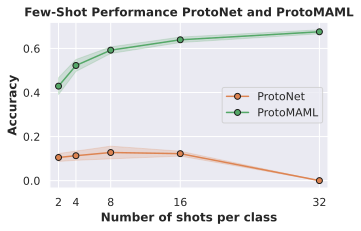

In [29]:
ax = plot_few_shot(protonet_accuracies, name="ProtoNet", color="C1")
plot_few_shot(protomaml_accuracies, name="ProtoMAML", color="C2", ax=ax)
plt.show()
plt.close()